In [68]:
import json
import string
import random 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

You should consider upgrading via the 'c:\users\joaqu\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\joaqu\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [31]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-07-27 15:01:23 INFO: Downloading default packages for language: es (Spanish)...
2022-07-27 15:01:27 INFO: File exists: C:\Users\joaqu\stanza_resources\es\default.zip.
2022-07-27 15:01:37 INFO: Finished downloading models and saved to C:\Users\joaqu\stanza_resources.
2022-07-27 15:01:37 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-07-27 15:01:37 INFO: Use device: gpu
2022-07-27 15:01:37 INFO: Loading: tokenize
2022-07-27 15:01:57 INFO: Loading: mwt
2022-07-27 15:01:57 INFO: Loading: pos
2022-07-27 15:01:58 INFO: Loading: lemma
2022-07-27 15:01:59 INFO: Loading: depparse
2022-07-27 15:02:00 INFO: Loading: ner
2022-07-27 15:02:07 INFO: Done loading processors!


In [87]:
import re
import unicodedata 
class bot:
    is_train = False
    words = []
    classes = []
    doc_X = []
    doc_y = []

    def preprocessing_text(self, text):
        text=text.lower()
        # sacar tildes de las palabras
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        # quitar caracteres especiales
        pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
        text = re.sub(pattern, '', text)
        pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
        # quitar números
        text = re.sub(pattern, '', text)
        # quitar caracteres de puntiación
        text = ''.join([c for c in text if c not in string.punctuation])
        return text

    def preprocessing_example(self, text):
        tokes = nlp(self.preprocessing_text(text))
        print("tokens:", tokes)
        print("Lematización de cada token:")
        for token in tokes:
            print([token, token.lemma_])

    def dataset(self, dataset):
        for intent in dataset["intents"]:
            for pattern in intent["patterns"]:
                # trasformar el patron a tokens
                tokens = nlp(self.preprocessing_text(pattern))
                # lematizar los tokens
                for token in tokens:            
                    self.words.append(token.lemma_)
                
                self.doc_X.append(pattern)
                self.doc_y.append(intent["tag"])
            
            # Agregar el tag a las clases
            if intent["tag"] not in self.classes:
                self.classes.append(intent["tag"])

        # Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
        words = sorted(set(self.words))
        classes = sorted(set(self.classes))

    def dataset_check(self):
        print("words:", self.words)
        print("classes:", self.classes)
        print("doc_X:", self.doc_X)
        print("doc_y:", self.doc_y)

    def one_hot_encoding(self):
        # Transformar doc_X en bag of words por oneHotEncoding
        # Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

        training = []
        out_empty = [0] * len(self.classes)

        for idx, doc in enumerate(self.doc_X):
            # Transformar la pregunta (input) en tokens y lematizar
            text = []
            tokens = nlp(self.preprocessing_text(doc))
            for token in tokens:
                text.append(token.lemma_)

            # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
            bow = []
            for word in self.words:
                bow.append(1) if word in text else bow.append(0)
            
            # Crear el array de salida (class output) correspondiente
            output_row = list(out_empty)
            output_row[self.classes.index(self.doc_y[idx])] = 1

            print("X:", bow, "y:", output_row)
            training.append([bow, output_row])

        # Mezclar los datos
        random.shuffle(training)
        training = np.array(training, dtype=object)
        # Dividir en datos de entrada y salida
        self.train_X = np.array(list(training[:, 0]))
        self.train_y = np.array(list(training[:, 1]))

    def training(self, visualization):
        # Shape de entrada y salida
        input_shape = (self.train_X.shape[1],)
        output_shape = self.train_y.shape[1]
        print("input:", input_shape, "output:", output_shape)
        # Entrenamiento del modelo DNN
        # - Modelo secuencial
        # - Con regularización
        # - softmax y optimizador Adam
        self.model = Sequential()
        self.model.add(Dense(200, input_shape=input_shape, activation="relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(100, activation="relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(50, activation="relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(output_shape, activation = "softmax"))

        self.model.compile(loss='categorical_crossentropy',
                    optimizer="Adam",
                    metrics=["accuracy"])
        print(self.model.summary())
        hist = self.model.fit(x=self.train_X, y=self.train_y, epochs=200)

        if visualization == True:
            epoch_count = range(1, len(hist.history['accuracy']) + 1)
            sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
            plt.show()

    def save_model(self, name):
        pickle.dump(self.words, open(name + '_words.pkl','wb'))
        pickle.dump(self.classes, open(name + '_classes.pkl','wb'))
        self.model.save(name + '_chatbot_model.h5')


In [66]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es TiendaPro", "Yo soy TiendaPro"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?"],
              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros productos en stock"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?"],
              "responses": ["Los productos publicados están en stock"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

tokens: hola chao
Lematización de cada token:
[hola, 'holar']
[chao, 'chao']
words: ['holar', 'como', 'este', 'que', 'tal', 'cual', 'ser', 'tu', 'nombre', 'quien', 'ser', 'contacto', 'numero', 'de', 'contacto', 'numero', 'de', 'telefono', 'numero', 'de', 'whatsapp', 'whatsapp', 'realizar', 'envio', 'como', 'yo', 'llegar', 'el', 'paquete', 'precio', 'yo', 'poder', 'pasar', 'el', 'precio', 'cuanto', 'valer', 'cuanto', 'salir', 'medio', 'de', 'pago', 'tarjeta', 'de', 'credito', 'tarjeta', 'cuota', 'este', 'este', 'disponible', 'tener', 'stock', 'haber', 'stock', 'hoy', 'mucho', 'gracias', 'gracias', 'chau', 'hasta', 'luego']
classes: ['bienvenida', 'nombre', 'contacto', 'envios', 'precios', 'pagos', 'stock', 'agradecimientos', 'despedida']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', '¿Realizan envios?', '¿Cómo me llega el paquete?', 'precio', 'Me podrás pasar lo

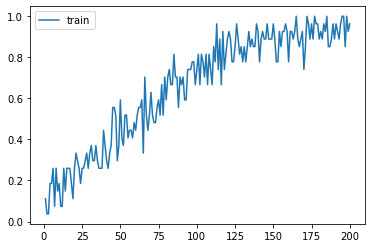

In [88]:
bot_1 = bot()
bot_1.preprocessing_text("Híñ!4")
bot_1.preprocessing_example("hola chao")

bot_1.dataset(dataset)
bot_1.dataset_check()
bot_1.one_hot_encoding()
bot_1.training(visualization=True)
bot_1.save_model("name")